In [ ]:
import torch

def inverted_pendulum_linear(x, u, m=0.2, M=1.0, L=0.5, g=9.81):
    A = torch.tensor([
        [0, 1, 0, 0],
        [0, 0, (m * g) / M, 0],
        [0, 0, 0, 1],
        [0, 0, ((M + m) * g) / (M * L), 0]
    ])
    
    B = torch.tensor([[0, 1 / M, 0, 1 / (M * L)]]).T

    # Compute the state derivatives
    state_dot = torch.matmul(A, x) + torch.matmul(B, u)

    return state_dot
    
def simulate_inverted_pendulum(initial_state, target_state, pid, dt, t_end, m=0.2, M=1.0, L=0.5, g=9.81):
    state = initial_state.detach()
    u = torch.zeros((1, state.shape[1]))
    error = target_state[2] - state[2]
    error_intg = error.detach()
    
    states, us, errors = [], [], []  # Store states for plotting or analysis
    time = torch.arange(0, t_end, dt)
    for t in time:
        states.append(state.detach())
        us.append(u.detach())
        errors.append(error.detach())
        
        error = target_state[2] - state[2]
        
        state_dot = inverted_pendulum_linear(state, u, m, M, L, g)
        state_next = state + state_dot * dt
        error_next = target_state[2] - state_next[2]
        error_diff = error_next - error
        
        u_prop = error * pid[0:1]
        u_intg = error_intg * pid[1:2]
        u_diff = error_diff * pid[2:3]
        u = u_prop + u_intg + u_diff
        
        state = state_next.detach()
        error = error_next.detach()
        error_intg = error_intg + error

    return torch.stack(states), torch.stack(us), torch.stack(errors), time

In [3]:
def dec_to_bin(x, bits):
    # mask = 2 ** torch.arange(bits).to(x.device, x.dtype)
    mask = 2 ** torch.arange(bits - 1, -1, -1)
    return x.int().unsqueeze(-1).bitwise_and(mask).ne(0).float()

def bin_to_dec(b, bits):
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(b.device, b.dtype)
    return torch.sum(mask * b, -1).int()

def encode_pid(pid, bits):
    encoded_pid = torch.concat([
        dec_to_bin(pid[0, :], bits),
        dec_to_bin(pid[1, :], bits),
        dec_to_bin(pid[2, :], bits),
    ], axis=1)
    
    return encoded_pid

def decode_pid(encoded_pid, bits):
    p = bin_to_dec(encoded_pid[:, bits * 0:bits * 1], bits)
    i = bin_to_dec(encoded_pid[:, bits * 1:bits * 2], bits)
    d = bin_to_dec(encoded_pid[:, bits * 2:bits * 3], bits)
    
    return torch.stack([p, i, d])

def judge_population(pid, initial_state, target_state, dt=0.01, t_end=1):
    n = pid.shape[1]

    _, _, errors, _ = simulate_inverted_pendulum(initial_state, target_state, pid, dt, t_end)

    fitness = 1 / torch.abs(errors).sum(axis=0).unsqueeze(0)
    pid_with_fitness = torch.concat((fitness, pid), axis=0)
    sorted_pid = pid_with_fitness[:, pid_with_fitness[0, :].sort(descending=True)[1]]
    selection_chance = sorted_pid[0].detach() / sorted_pid[0].sum()
    cumulative_chance = selection_chance.clone()
    for i in range(1, len(cumulative_chance)):
        cumulative_chance[i] = cumulative_chance[i - 1].clone() + cumulative_chance[i].clone()
    
    return sorted_pid, selection_chance, cumulative_chance, fitness.mean()

def select_solution(cumulative_chance):
    rnd = torch.rand(1).item()
    max_idx = torch.tensor(cumulative_chance.shape[0] - 1)
    sel_idx = torch.less(cumulative_chance, rnd).sum()
    
    return torch.min(sel_idx, max_idx)

def make_child(mum, dad):
    # Crossover
    child = torch.zeros_like(mum)
    idx = 0
    while idx < len(mum):
        chunk_size = (torch.rand(1)*30).int().item()
        if torch.rand(1).item() > 50:
            child[idx:idx + chunk_size] = mum[idx:idx + chunk_size].clone()
        else:
            child[idx:idx + chunk_size] = dad[idx:idx + chunk_size].clone()
            
        idx += chunk_size

    # Mutation
    mutation_chance = 0.05
    for idx in range(len(mum)):
        if torch.rand(1).item() > mutation_chance:
            child[idx] = 1 - child[idx]
            
    return child

def step_generation(encoded_pop, cumulative_chance, elite_ratio=0.2, new_ratio=0.2):
    n = encoded_pop.shape[0]
    n_elite = (int)(n * elite_ratio)
    n_new = (int)(n * new_ratio)
    new_pop = [encoded_pop[i] for i in range(n_elite)]
    new_pop += [torch.greater(torch.rand(30), 0.5).float() for _ in range(n_new)]
    for i in range(n - n_elite - n_new):
        mum = encoded_pop[select_solution(cumulative_chance)]
        dad = encoded_pop[select_solution(cumulative_chance)]
        new_pop.append(make_child(mum, dad))
        
    return new_pop

def evolve_population(n, initial_state, target_state, generations):
    population = (torch.rand((3, n)) * 1023).int()
    sorted_pop, sel_chance, cum_chance, mean_fitness = judge_population(
        population,
        initial_state,
        target_state,
        dt=0.01,
        t_end=0.5
        )
    print(f"initial mean fitness: {mean_fitness}")

    for gen in range(generations):
        encoded_pop = encode_pid(sorted_pop[1:], 10)
        next_generation = step_generation(encoded_pop, cum_chance)
        next_encoded_pop = torch.stack(next_generation)
        next_population = decode_pid(next_encoded_pop, 10)
        
        sorted_pop, sel_chance, cum_chance, mean_fitness = judge_population(
            next_population,
            initial_state,
            target_state,
            dt=0.01,
            t_end=0.5
            )
        print(f"gen: {gen + 1}, mean fitness: {mean_fitness:.4f}")
        
    return next_population

In [4]:
dt, t_end, n, generations = 0.01, 0.5, 3000, 200

initial_state = torch.tensor([[0.0, 0.0, 0.2, 0.0] for _ in range(n)]).T
target_state = torch.tensor([[0.0, 0.0, 0.0, 0.0] for _ in range(n)]).T

pop = evolve_population(n, initial_state, target_state, generations)


initial mean fitness: 0.002137518720701337
gen: 1, mean fitness: 0.0025
gen: 2, mean fitness: 0.0030
gen: 3, mean fitness: 0.0034
gen: 4, mean fitness: 0.0038
gen: 5, mean fitness: 0.0041
gen: 6, mean fitness: 0.0044
gen: 7, mean fitness: 0.0048
gen: 8, mean fitness: 0.0054
gen: 9, mean fitness: 0.0055
gen: 10, mean fitness: 0.0058
gen: 11, mean fitness: 0.0061
gen: 12, mean fitness: 0.0064
gen: 13, mean fitness: 0.0069
gen: 14, mean fitness: 0.0072
gen: 15, mean fitness: 0.0075
gen: 16, mean fitness: 0.0077
gen: 17, mean fitness: 0.0080
gen: 18, mean fitness: 0.0081
gen: 19, mean fitness: 0.0083
gen: 20, mean fitness: 0.0084
gen: 21, mean fitness: 0.0086
gen: 22, mean fitness: 0.0090
gen: 23, mean fitness: 0.0092
gen: 24, mean fitness: 0.0094
gen: 25, mean fitness: 0.0096
gen: 26, mean fitness: 0.0098
gen: 27, mean fitness: 0.0102
gen: 28, mean fitness: 0.0105
gen: 29, mean fitness: 0.0108
gen: 30, mean fitness: 0.0109
gen: 31, mean fitness: 0.0112
gen: 32, mean fitness: 0.0114
gen: 3

In [6]:
states, us, errors, time = simulate_inverted_pendulum(
    initial_state,
    target_state,
    pop[:, 0:1],
    dt=dt,
    t_end=3
    )

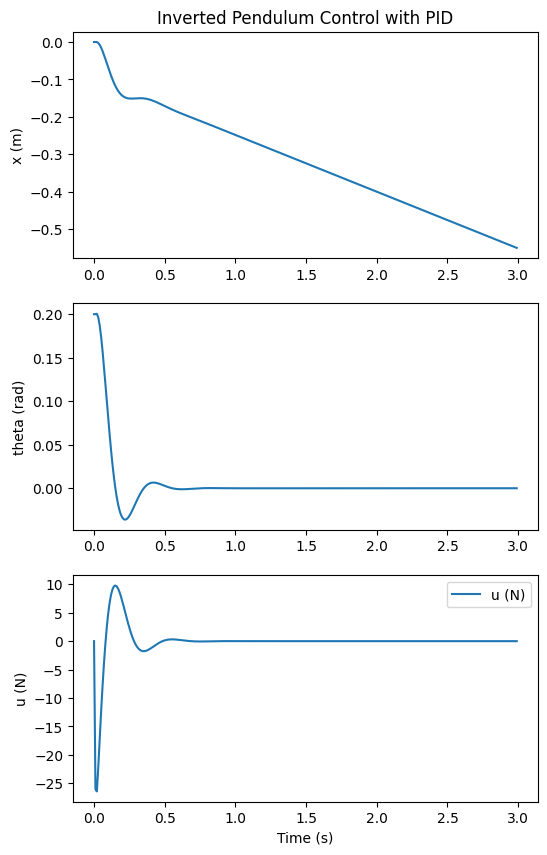

In [7]:
# Plot results
import matplotlib.pyplot as plt

n = 0
plt.figure(figsize=(6, 10))
plt.subplot(3, 1, 1)
plt.title("Inverted Pendulum Control with PID")
plt.plot(time, states[:, 0, n], label="Cart Position (x)")
plt.ylabel("x (m)")
plt.subplot(3, 1, 2)
plt.plot(time, states[:, 2, n], label="Pendulum Angle (theta)")
plt.ylabel("theta (rad)")
plt.subplot(3, 1, 3)
plt.plot(time, us[:, 0, n], label="u (N)")
plt.ylabel("u (N)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()